#Woody Area Index Estimates for National Ecological Observatory Network (NEON) Evergreen Forest Sites

This notebook provides summary statistics and visualization of results of work performed to estimate woody area index for NEON evergreen forest sites.

For each NEON site, the work consisted of steps resulting in output recorded in indicated excel worksheets:
1.  Identifying NEON Evergreen forest sites based on a spreadsheet provided by Luke Brown evergreensl2p) and the elementary sampling units (ESUs) in the site.
2.  Downloading early season (usually April) digital hemispherical photographs measured at one or more reference ESUs.
3.  Estimating Plant area index (PAI) and leaf area index (LAI) by processnig each sampled date using a combination of NXStudio and CANEYE. (CANEYE_singledate)
4.  Estimating woody area index (WAI) for the sample as PAI-LAI and adjusting this estimate to correct for systematic differences between NEON and CANEYE PAI.
5.  Estimating LAI for all other sampled dates at the same reference ESU by subtracting the corrected WAI from NEON PAI. (CANEYE_temporal_interpolation)
6.  Estimating WAI at all other ESUs in the same site as the adjusted reference WAI for the reference sample with the closest LAI match. (NEON_2013-22_RMs_evergreen)

Configuration of Environment

In [0]:
pip install openpyxl

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
  Obtaining dependency information for openpyxl from https://files.pythonhosted.org/packages/c0/da/977ded879c29cbd04de313843e76868e6e13408a94ed6b987245dc7c8506/openpyxl-3.1.5-py2.py3-none-any.whl.metadata
  Obtaining dependency information for et-xmlfile from https://files.pythonhosted.org/packages/96/c2/3dd434b0108730014f1b96fd286040dc3bcb70066346f7e01ec2ac95865f/et_xmlfile-1.1.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/250.9 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 8.0 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
#Import modules
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr
from scipy.stats.stats import theilslopes

/root/.ipykernel/1060/command-45924128605380-2382799110:6: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr
/root/.ipykernel/1060/command-45924128605380-2382799110:7: DeprecationWarning: Please use `theilslopes` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import theilslopes


Data Ingest

In [0]:
# read in worksheets

io = '/dbfs/FileStore/tables/validation/NEON_2013_22_RMs_CANEYE.xlsx'
dfCANEYE = pd.read_excel(io, sheet_name='CANEYE_singledate', header=0)
dfCANEYE_Temporal = pd.read_excel(io, sheet_name='CANEYE_temporal_interpolation', header=0) 
dfNEON_evergreen = pd.read_excel(io, sheet_name='NEON_2013-22_RMs_evergreen', header=0)   
dfSL2P_evergreen = pd.read_excel(io, sheet_name='evergeensl2p', header=0)   

In [0]:
#rename columns of dfCANEYE

dfCANEYE.rename(columns={'PAI CANEYE ': 'PAI CANEYE', 'true_LAI_Miller_overstory': 'PAI Miller', 'true_LAI_Warren_overstory': 'PAI Warren','WAIref_Miller':"WAIref Miller", 'WAIref_Warren':"WAIref Warren"}, inplace=True)

In [0]:
#drop bad SOAP measurements (luke did not use them but they are present and could impact my work)
dfCANEYE_Temporal= dfCANEYE_Temporal.drop(dfCANEYE_Temporal[(dfCANEYE_Temporal['SITE']=='SOAP') & (dfCANEYE_Temporal['true_PAI_Warren']>1.4)].index)

In [0]:

#remove incorrect SOAP samples and sites not used in lukes paper and compute derived values
dfNEON_evergreen= dfNEON_evergreen.drop(dfNEON_evergreen[(dfNEON_evergreen['SITE']=='SOAP') & (dfNEON_evergreen['true_PAI_Warren']>1.4)].index)
dfNEON_evergreen= dfNEON_evergreen.loc[dfNEON_evergreen['LAI/PAI_ratio_maximum']>-999]
dfNEON_evergreen['datetime'] = pd.to_datetime(dfNEON_evergreen['datetime'], dayfirst=True)
dfNEON_evergreen['ordinalDate'] = dfNEON_evergreen['datetime'].apply(lambda x: x.toordinal())
dfNEON_evergreen['estimated_LAI_Warren'] = dfNEON_evergreen['true_PAI_Warren'] * dfNEON_evergreen['LAI/PAI_ratio_maximum'] 
dfNEON_evergreen['estimated_LAI_Miller'] = dfNEON_evergreen['true_PAI_Miller'] * dfNEON_evergreen['LAI/PAI_ratio_maximum'] 
dfNEON_evergreen['WAI_PAI_ratio_Warren'] = (1-dfNEON_evergreen['LAI/PAI_ratio_maximum'] )
dfNEON_evergreen['WAI_PAI_WAI_ratio_Miller'] = (1-dfNEON_evergreen['LAI/PAI_ratio_maximum'] )
dfNEON_evergreen['WAI_Warren'] = dfNEON_evergreen['true_PAI_Warren'] * (1-dfNEON_evergreen['LAI/PAI_ratio_maximum'] )
dfNEON_evergreen['WAI_Miller'] = dfNEON_evergreen['true_PAI_Miller'] * (1-dfNEON_evergreen['LAI/PAI_ratio_maximum'] )

dfNEON_evergreen['baseline_LAI_Warren'] = dfNEON_evergreen['true_PAI_Warren'] * 0.84
dfNEON_evergreen['baseline_LAI_Miller'] = dfNEON_evergreen['true_PAI_Miller'] * 0.84
dfNEON_evergreen['delta_LAI_Warren'] = dfNEON_evergreen['estimated_LAI_Warren'] - dfNEON_evergreen['baseline_LAI_Warren']
dfNEON_evergreen['delta_LAI_Miller'] = dfNEON_evergreen['estimated_LAI_Miller'] - dfNEON_evergreen['baseline_LAI_Miller']


CANEYE Results

In [0]:
#Thiel Sen line fits
e1 = theilslopes(dfCANEYE['WAI CANEYE'], dfCANEYE['PAI CANEYE'], alpha=0.95, method='separate')
e2 = theilslopes(dfCANEYE['WAIref Miller'], dfCANEYE['PAI Miller'], alpha=0.95, method='separate')
e3 = theilslopes(dfCANEYE['WAIref Warren'], dfCANEYE['PAI Warren'], alpha=0.95, method='separate')
e4 = theilslopes(dfCANEYE['PAI CANEYE'], dfCANEYE['PAI Miller'], alpha=0.95, method='separate')
e5 = theilslopes(dfCANEYE['PAI CANEYE'], dfCANEYE['PAI Warren'], alpha=0.95, method='separate')
e6 = theilslopes(dfCANEYE['PAI Miller'], dfCANEYE['PAI Warren'], alpha=0.95, method='separate')
r1 = pearsonr(dfCANEYE['WAI CANEYE'], dfCANEYE['PAI CANEYE'])
r2 = pearsonr(dfCANEYE['WAIref Miller'], dfCANEYE['PAI Miller'])
r3 = pearsonr(dfCANEYE['WAIref Warren'], dfCANEYE['PAI Warren'])
r4 = pearsonr(dfCANEYE['PAI CANEYE'], dfCANEYE['PAI Miller'])
r5 = pearsonr(dfCANEYE['PAI CANEYE'], dfCANEYE['PAI Warren'])
r6 = pearsonr(dfCANEYE['PAI Miller'], dfCANEYE['PAI Warren'])


In [0]:
print(r1.statistic,e1.slope,e1.low_slope,e1.high_slope,e1.intercept,)
print(r2.statistic,e2.slope,e2.low_slope,e2.high_slope,e2.intercept)
print(r3.statistic,e3.slope,e3.low_slope,e3.high_slope,e3.intercept)
print(r4.statistic,e4.slope,e4.low_slope,e4.high_slope,e4.intercept)
print(r5.statistic,e5.slope,e5.low_slope,e5.high_slope,e5.intercept)
print(r6.statistic,e6.slope,e6.low_slope,e6.high_slope,e6.intercept)


0.9804060914827274 0.6836363636363635 0.6318407960199006 0.7407407407407407 -0.07003636363636323
0.972001714720163 0.6736191255313865 0.5973680640347306 0.7354559748427676 -0.1598761999950793
0.9641108013551721 0.6805267448874099 0.6089335317460319 0.7515151515151515 -0.06471010540999966
0.938587446974299 0.8592233009708737 0.7173913043478263 0.986301369863014 -0.17184466019417455
0.9178072160771781 0.9513557936480328 0.7894736842105262 1.0990990990990992 -0.12795480832782546
0.9715110914711478 1.071919191919192 0.955431754874652 1.1376146788990824 0.1215212121212117


/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


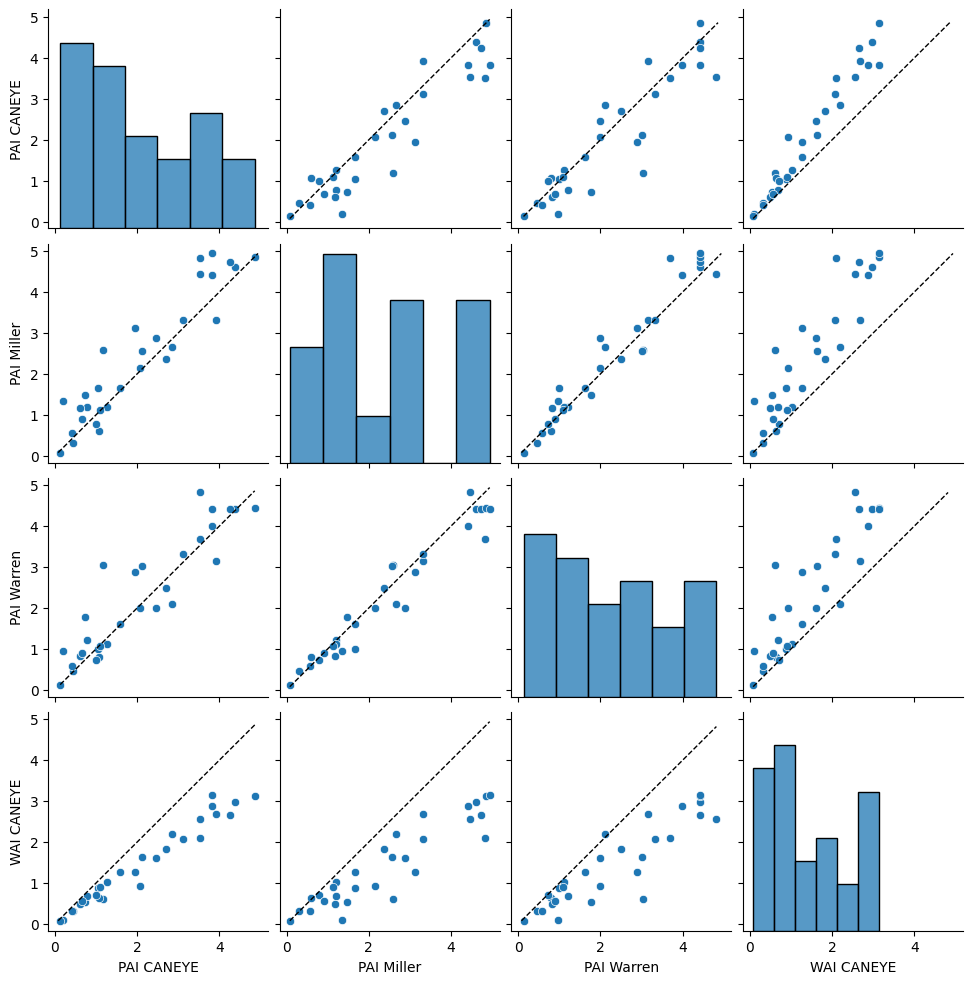

In [0]:
def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='k', marker=None,
            linestyle='--', linewidth=1.0)
grid = sns.pairplot(data=dfCANEYE[['PAI CANEYE','PAI Miller','PAI Warren','WAI CANEYE']])
grid.map_offdiag(plot_unity)

Temporal Interpolation Results

(0.0, 6.0)

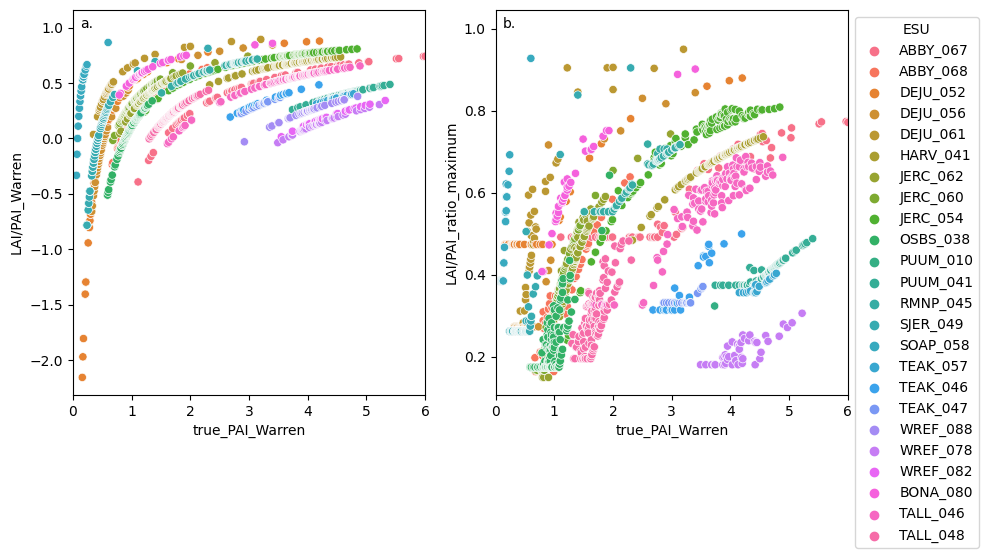

In [0]:
#Time Series of Reference WAI
fig, axs = plt.subplots(1,2,figsize=( 10, 5))

p1 = sns.scatterplot(data=dfCANEYE_Temporal,x='true_PAI_Warren',y='LAI/PAI_Warren',hue='PLOT_ID',legend=False,ax=axs[0])
axs[0].annotate("a.", xy=(0,1), xycoords="axes fraction",
                    xytext=(5,-5), textcoords="offset points",
                    ha="left", va="top")
p1 = sns.scatterplot(data=dfCANEYE_Temporal,x='true_PAI_Warren',y='LAI/PAI_ratio_maximum',hue='PLOT_ID',legend=True,ax=axs[1])
axs[1].annotate("b.", xy=(0,1), xycoords="axes fraction",
                    xytext=(5,-5), textcoords="offset points",
                    ha="left", va="top")
sns.move_legend(p1, "upper left", bbox_to_anchor=(1, 1), title='ESU')
axs[0].set_xlim([0, 6])
axs[1].set_xlim([0, 6])


Final results of estimated WAI and comparison of estimate LAI to LAI assuming 0.84 LAI/PAI ratio

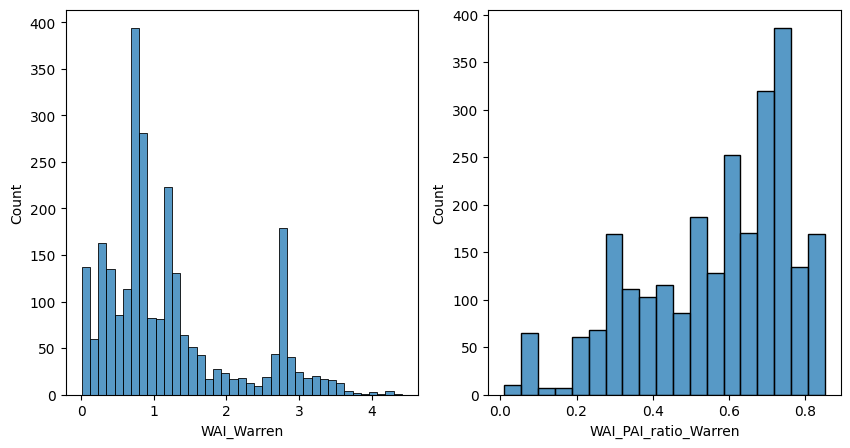

In [0]:
#WAI Histograms
fig, axs = plt.subplots(1,2,figsize=( 10, 5))

p1 = sns.histplot(data=dfNEON_evergreen.loc[dfNEON_evergreen['WAI_Warren']>0],x='WAI_Warren',ax=axs[0])

p2 = sns.histplot(data=dfNEON_evergreen.loc[dfNEON_evergreen['WAI_PAI_ratio_Warren']>0],x='WAI_PAI_ratio_Warren',ax=axs[1])

(0.0, 6.0)

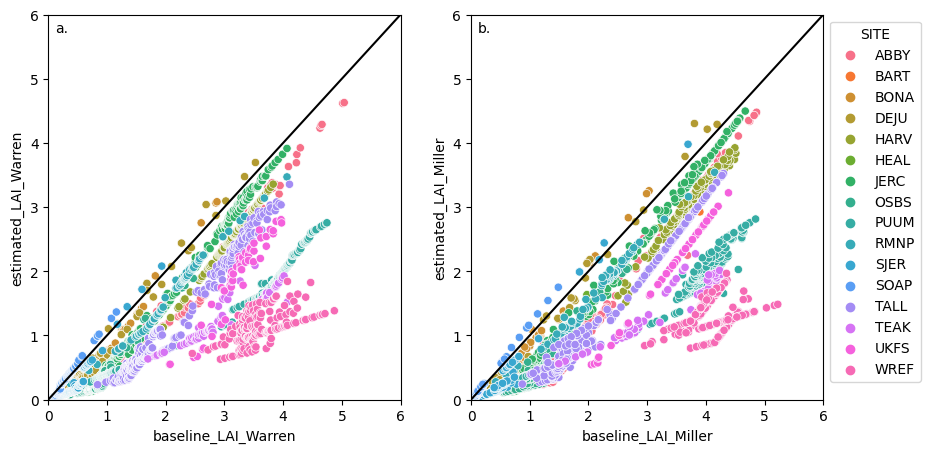

In [0]:
#Plots of Nominal versus Estimated LAI
fig, axs = plt.subplots(1,2,figsize=( 10, 5))

p1 = sns.scatterplot(data=dfNEON_evergreen,x='baseline_LAI_Warren',y='estimated_LAI_Warren',hue='SITE',legend=False,ax=axs[0])
axs[0].annotate("a.", xy=(0,1), xycoords="axes fraction",
                    xytext=(5,-5), textcoords="offset points",
                    ha="left", va="top")
axs[0].plot([0,6],[0,6],'k')

p2 = sns.scatterplot(data=dfNEON_evergreen,x='baseline_LAI_Miller',y='estimated_LAI_Miller',hue='SITE',legend=True,ax=axs[1])
axs[1].plot([0,6],[0,6],'k')
axs[1].annotate("b.", xy=(0,1), xycoords="axes fraction",
                    xytext=(5,-5), textcoords="offset points",
                    ha="left", va="top")
sns.move_legend(p2, "upper left", bbox_to_anchor=(1, 1), title='SITE')

axs[0].set_xlim([0, 6])
axs[1].set_xlim([0, 6])
axs[0].set_ylim([0, 6])
axs[1].set_ylim([0, 6])
